# BACKPROJECT IMAGE CLASSIFICATION RESULTS ONTO THE POINT CLOUD

In [1]:
from rdflib import Graph, URIRef
import os.path
import importlib
import numpy as np
import xml.etree.ElementTree as ET
import open3d as o3d
import uuid    
import pye57 
import ifcopenshell
import ifcopenshell.geom as geom
import ifcopenshell.util
import ifcopenshell.util.selector
import random as rd
import pandas as pd
import cv2
import laspy
import copy
from matplotlib import pyplot as plt
import math
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow import keras
#IMPORT MODULES
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.tools import progresstools as pt
from geomapi.utils import imageutils as iu
import geomapi.tools as tl

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## USER INPUT

general

In [4]:
projectPath= os.path.join("D:\\Data\\2023-01 Paestum")
sessionPath = os.path.join(projectPath,"Research")

test1

In [5]:
#PCD
lasPath=os.path.join(projectPath,"PCD","TEMPIO_all_predicted - Cloud.las")
outputlasPath=os.path.join(projectPath,"PCD","paestum_test1_out.las")
transform=np.array([[1.0,0.0, 0.0,  5.3857862609899980e+000], 
                [0.0, 1.0, 0.0, 2.5782303777102851e+002],
                [0.0, 0.0, 1.0 ,-6.0074548600459288e+000],
                [0.0 ,0.0, 0.0, 1.000000000000]]) # -> apply to pcd
scale=1/1.8781217664810130e+000 # -> apply to pcd

# -10
# +10
#  5.3857862609899980e+000
# 2.5782303777102851e+002 
#Images
xmlPath=os.path.join(projectPath,'IMG','cameras.xml')
sensorid=1
focalLength35mm= 2428.49184473261
rotation=np.array([[-9.9927572727173009e-001, -9.2989357887395263e-003 ,3.6899196180300041e-002,0],
                        [ 3.4752208827689118e-002, 1.7201294833769601e-001, 9.8448150291702796e-001,0],
                        [-1.5501769807091738e-002, 9.8505079838421061e-001 , -1.7156520549190035e-001,0],
                        [0,0,0,1]]) # -> apply to images
       
#classification
# modelMPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2__materials")
# modelTCPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2_BuildingTechniques")
# modelDPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2_Damages")
trainingsfolder=pathlib.Path(os.path.join(sessionPath,'Classification_test1','temp'))
tf_image_folder=pathlib.Path(os.path.join(sessionPath,'Classification_test1','im_temp'))
tf_mask_folder=pathlib.Path(os.path.join(sessionPath,'Classification_test1','mask_temp'))


# tempfolder=pathlib.Path(os.path.join(sessionPath,'Facade_classification','temp'))
# batch_size = 32 #! same as model
# class_names_m=[0.0,1.0]
# class_names_tc=[0.0,1.0,2.0]
# class_names_d=[1.0,2.0]
imagePath=os.path.join(projectPath,'Research')
# filteringWeight=3
# colors=[(255,0,0),(0,255,0),(0,0,255)]
# pixelRange=224
# rayOffsetDistance=0.2
skip=10 #nth file tu use


## PREPROCESS POINT CLOUD

Create point cloud node with proper offset.

In [6]:
las  = laspy.read(lasPath)
pcdNode=PointCloudNode(name=ut.get_filename(lasPath),
                        lasPath=lasPath,
                        resource=gmu.las_to_pcd(las,transform=transform)
                        )
pcdNode.resource.scale(scale,(0,0,0)) #pcdNode.resource.get_center()

PointCloud with 2785923 points.

## PREPROCESS THE IMAGES WITH THE POINT CLOUD

Create imageNodes with proper offset.

In [7]:
#get list of files
files=ut.get_list_of_files(ut.get_folder(xmlPath))
files=[f for f in files if f.endswith('.JPG')]

#select every fifth files
imgNodes=[]
for f in files[0::skip]:    
    imgNodes.append(ImageNode(name=ut.get_filename(f),
              path=f,
              xmlPath=xmlPath,
                focalLength35mm=focalLength35mm))
# apply transform to put imagery in local coordinates
for n in imgNodes:
    n.cartesianTransform=rotation @ n.cartesianTransform 
    #apply scale -> only to tanslation
    # n.cartesianTransform[0:3,3] *= scale
       
meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
print(str(len(imgNodes))+ " Nodes created!")

90 Nodes created!


In [8]:
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': 'D:\\Data\\2023-01 Paestum\\IMG\\cameras.xml',
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 6048,
 'imageHeight': 4032,
 'focalLength35mm': 2428.49184473261,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///DSC_4226'),
 '_graph': None,
 '_graphPath': None,
 '_path': 'D:/Data/2023-01 Paestum/IMG/DSC_4226.JPG',
 '_name': 'DSC_4226',
 '_timestamp': '2014-06-06T17:21:42',
 '_resource': None,
 '_cartesianTransform': array([[  0.01816121,   0.99750693,  -0.06819158,   8.0859977 ],
        [ -0.42725536,   0.06940471,   0.90146317, -11.42426073],
        [  0.90394857,   0.01276355,   0.42745066,  -2.17309796],
        [  0.        ,   0.        ,   0.        ,   1.        ]]),
 'resolutionUnit': 2,
 'geospatialTransform': [None, None, None],
 'coordinateSystem': 'geospatial-wgs84'}

visualize the inputs

In [9]:
joinedImages=gmu.join_geometries(meshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([joinedImages]+[pcdNode.resource])
# o3d.visualization.draw_geometries([joinedImages]+[mesh])

# o3d.visualization.draw_geometries([joinedImages]+[myMesh])
# o3d.visualization.draw_geometries([joinedImages]+[octree])

NameError: name 'mesh' is not defined

colorize pcd per class

In [10]:
labels=las['Scalar field #15']
values=np.unique(labels)
pcd=copy.deepcopy(pcdNode.resource)
colors=np.array([ut.random_color() for v in range(len(values))])
colorArray=gmu.array_to_colors(labels,colors)
pcd.colors=o3d.utility.Vector3dVector(colorArray)

(optional) Get depth and class labels image per image from the point cloud

In [11]:
myImageNodes=imgNodes

In [ ]:
# colorImages1,depthImages1=pt.project_pcd_to_rgbd_images(pcd,myImageNodes,depth_max=30,fill_black=40)#
# for c,d,n in zip(colorImages1,depthImages1,myImageNodes): 
#     n.mask1=pt.remap_color_images_to_masks(c,colors)[0]
#     n.colorImage1=c 
#     n.depthImage1=d 

Get depth and class labels image per image from the octree

In [13]:
octree=pt.pcd_to_octree(pcd,8) #if octree is None else octree
mesh=gmu.octree_to_voxelmesh(octree) #if mesh is None else mesh
colorImages2,depthImages2=pt.project_meshes_to_rgbd_images(mesh, myImageNodes) # no depth filtering currently
for c,d,n in zip(colorImages2,depthImages2,myImageNodes): 
    n.mask2=pt.remap_color_images_to_masks(c,colors)[0]
    n.colorImage2=c 
    n.depthImage2=d 

Visualize some results

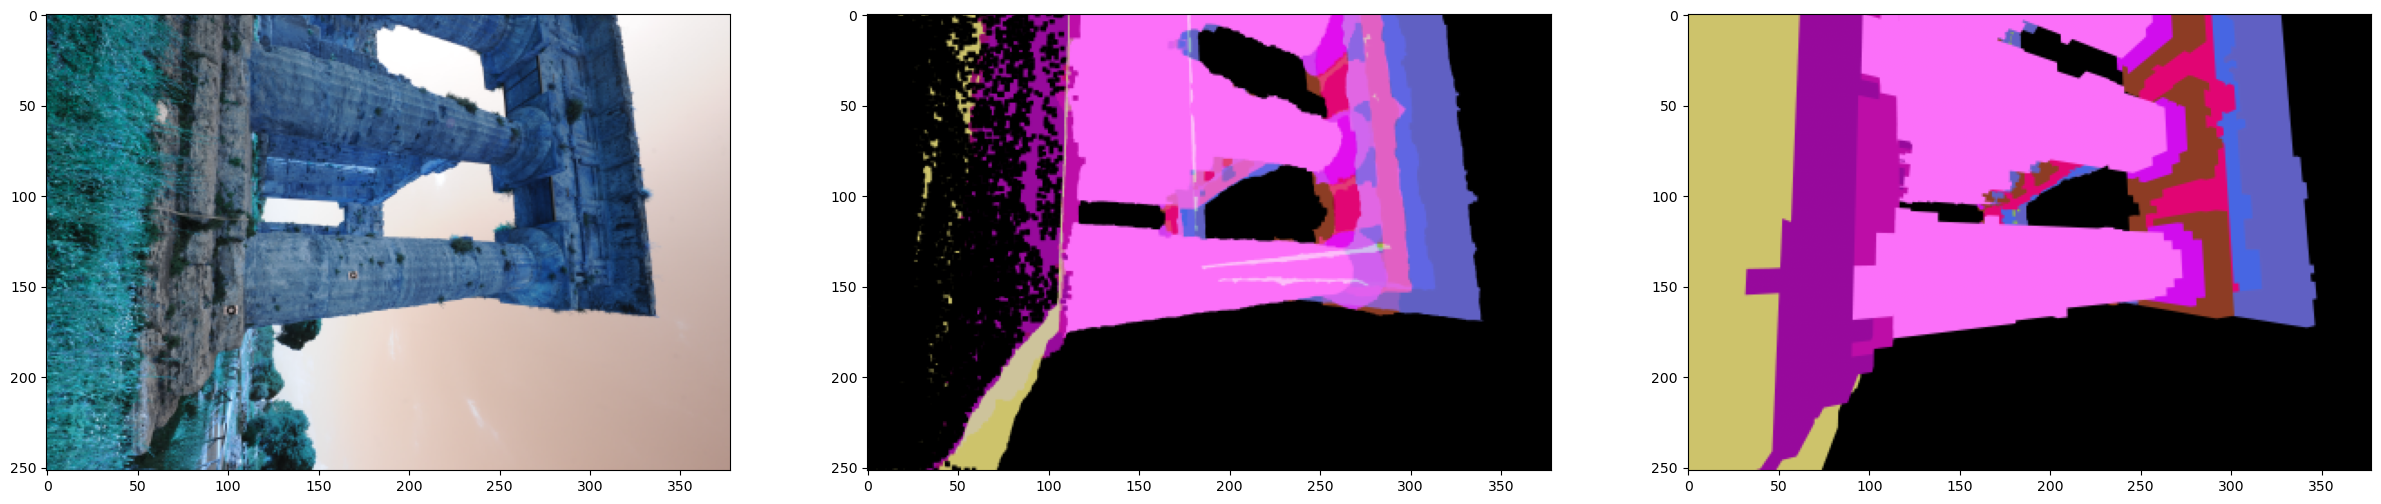

In [ ]:
from matplotlib import pyplot as plt
import math
n=imgNodes[0]
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
fig.set_facecolor("white")
axs[0].imshow(iu.image_resize(n.resource,scale=1/16))
axs[1].imshow(iu.image_resize(n.colorImage1,scale=1/16))
axs[2].imshow(iu.image_resize(n.colorImage2,scale=1/16))
plt.show()

(optional) write class labels to file.

In [ ]:
for n in imgNodes:
    path=os.path.join(trainingsfolder,n.name+'_depth.JPG')
    cv2.imwrite(path, n.depthImage2)

In [ ]:
import shutil

shutil.rmtree(trainingsfolder) if os.path.exists(trainingsfolder) else None 
os.mkdir(trainingsfolder) if not os.path.exists(trainingsfolder) else None                   

for n in imgNodes:
    #save to proper folders
    img=iu.grb01_to_rgb255(n.colorImage2)
    path=os.path.join(trainingsfolder,n.name+'.JPG')
    cv2.imwrite(path, img)
    # img=iu.grb01_to_rgb255(n.mask)
    path=os.path.join(trainingsfolder,n.name+'_mask.JPG')
    cv2.imwrite(path, n.mask2)

AttributeError: 'ImageNode' object has no attribute 'colorImage2'

# THE END

prepare samples conform tf dataset (class labels are int values from [0,1,2, ...] )

In [49]:
nodeList=[]
for n in imgNodes:

  imgList,roiList=iu.subdivide_image(n.resource,m=3,n=3,includeLast=True) 
  mask= np.repeat(n.mask[:, :, np.newaxis], 3, axis=2)
  mList,_=iu.subdivide_image(mask,m=3,n=3,includeLast=True)    

  for img,roi,m in zip(imgList,roiList,mList):
        nodeList.append(ImageNode(resource=img,
                                isDerivedFrom=n.subject,
                                roi=roi,
                                mask=m))  
import shutil

shutil.rmtree(tf_image_folder) if os.path.exists(tf_image_folder) else None 
os.mkdir(tf_image_folder) if not os.path.exists(tf_image_folder) else None     
shutil.rmtree(tf_mask_folder) if os.path.exists(tf_mask_folder) else None 
os.mkdir(tf_mask_folder) if not os.path.exists(tf_mask_folder) else None               
for n in nodeList:
    pathi=os.path.join(tf_image_folder,n.name+'.JPG')
    cv2.imwrite(pathi, n.resource)
    pathm=os.path.join(tf_mask_folder,n.name+'_mask.JPG')
    cv2.imwrite(pathm, n.mask)

Visualize some depth maps  

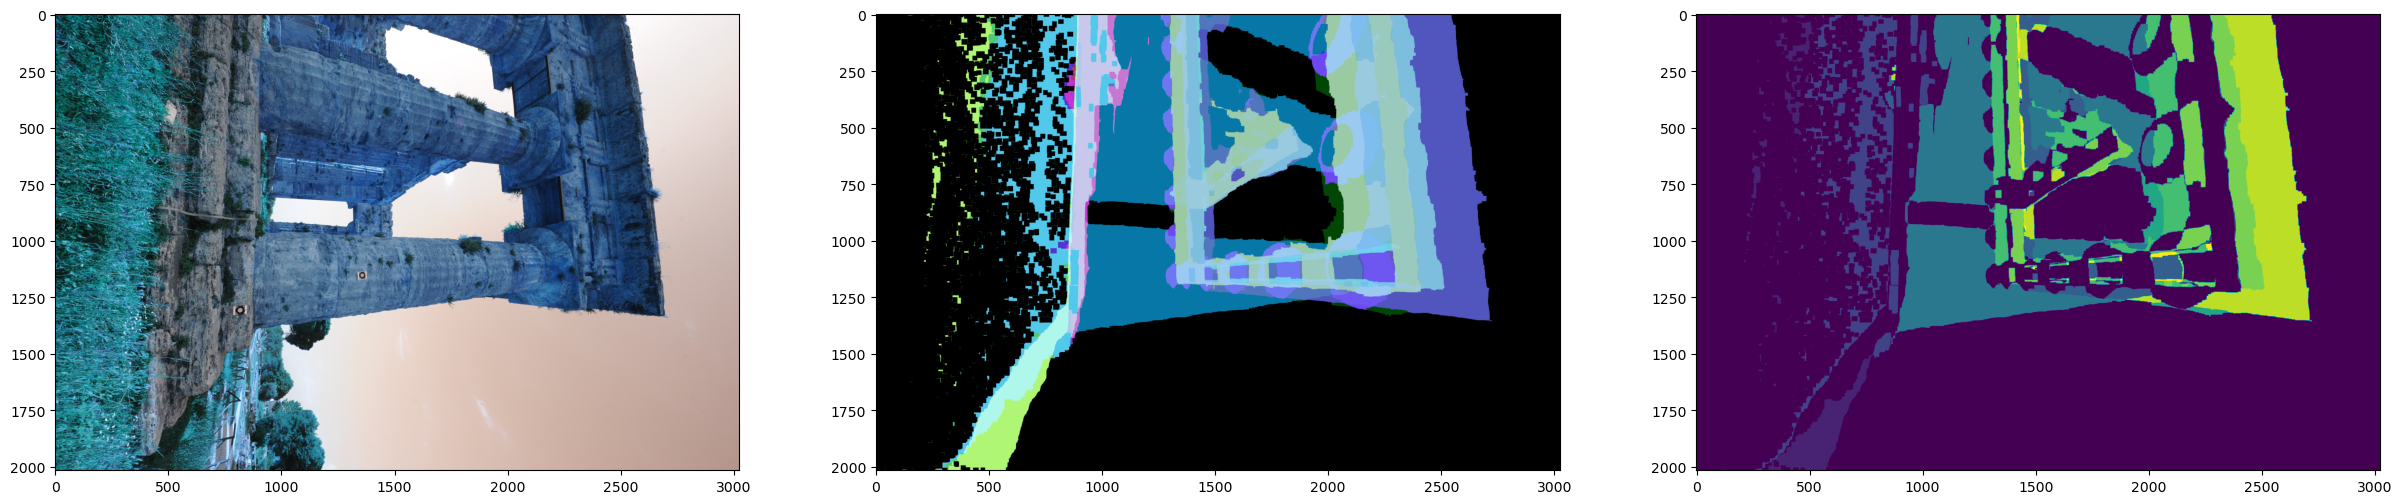

In [38]:
from matplotlib import pyplot as plt
import math
n=imgNodes[0]
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
fig.set_facecolor("white")
axs[0].imshow(iu.image_resize(n.resource,1/16))
axs[1].imshow(iu.image_resize(n.colorImage,1/16))
axs[2].imshow(iu.image_resize(n.mask,1/16))
plt.show()

subdivide images and raytrace the point cloud.

store subImages for classification

In [261]:
import shutil

os.mkdir(tempfolder) if not os.path.exists(tempfolder) else None                   
temp=os.path.join(tempfolder,'0.0')
shutil.rmtree(temp) if os.path.exists(temp) else None 
os.mkdir(temp) if not os.path.exists(temp) else None                   

for n in imgTrainingNodes:
    path=os.path.join(temp,n.name+'.png')
    cv2.imwrite(path, n.resource)

In [78]:
{key:value for key, value in imgTrainingNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 224,
 'imageHeight': 224,
 'focalLength35mm': None,
 '_subject': rdflib.term.URIRef('file:///27881d94-a607-11ed-8548-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': '27881d94-a607-11ed-8548-c8f75043ce59',
 '_timestamp': None,
 '_resource': array([[[102, 105, 103],
         [ 98, 101,  99],
         [111, 114, 112],
         ...,
         [137, 135, 127],
         [139, 137, 129],
         [137, 135, 127]],
 
        [[ 98, 101,  99],
         [102, 105, 103],
         [114, 117, 115],
         ...,
         [136, 134, 126],
         [140, 138, 130],
         [137, 135, 127]],
 
        [[111, 114, 112],
         [108, 111, 109],
         [110, 113, 111],
         ...,
         [133, 131, 123],
         [138, 136, 128],
         [135, 133, 125]],
 
        ...,
 
        [[109, 108, 110],
         [ 95,  94,  96],
         [ 85,  83,  83],
         ...,
         [ 81,  79,

## CLASSIFY IMAGES

prepare image dataset

In [262]:
dataset = tf.keras.utils.image_dataset_from_directory(
  tempfolder,
  labels='inferred',
  image_size=(pixelRange, pixelRange),
  batch_size=batch_size,
  shuffle=False)

#buffer for data performance
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

Found 76896 files belonging to 1 classes.


load models

In [263]:
modelTC = tf.keras.models.load_model(modelTCPath)
modelD = tf.keras.models.load_model(modelDPath)

predict material labels

In [264]:
modelM = tf.keras.models.load_model(modelMPath)
probability_model = tf.keras.Sequential([modelM, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(dataset)
predicted_id = tf.math.argmax(predictions, axis=-1).numpy().astype(np.int32)
class_names_m=np.array(class_names_m)
predicted_id_m=class_names_m[predicted_id]
del modelM

2403/2403 [==============================] - 598s 248ms/step


predict building technique labels

In [265]:
probability_model = tf.keras.Sequential([modelTC, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(dataset)
predicted_id = tf.math.argmax(predictions, axis=-1).numpy().astype(np.int32)
class_names_tc=np.array(class_names_tc)
predicted_id_tc=class_names_tc[predicted_id]

2403/2403 [==============================] - 597s 248ms/step


predict Damage labels

In [266]:
probability_model = tf.keras.Sequential([modelD, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(dataset)
predicted_id = tf.math.argmax(predictions, axis=-1).numpy().astype(np.int32)
class_names_d=np.array(class_names_d)
predicted_id_d=class_names_d[predicted_id]

2403/2403 [==============================] - 402s 166ms/step


assign labels to subImages

In [267]:
for n,m,tc,d in zip(imgTrainingNodes,predicted_id_m,predicted_id_tc,predicted_id_d):
    n.resource=None #! flush memory
    # n.materialPredictionProbability=p
    n.materialPrediction=m
    n.techniquePrediction=tc
    n.damagePrediction=d

show some classification results

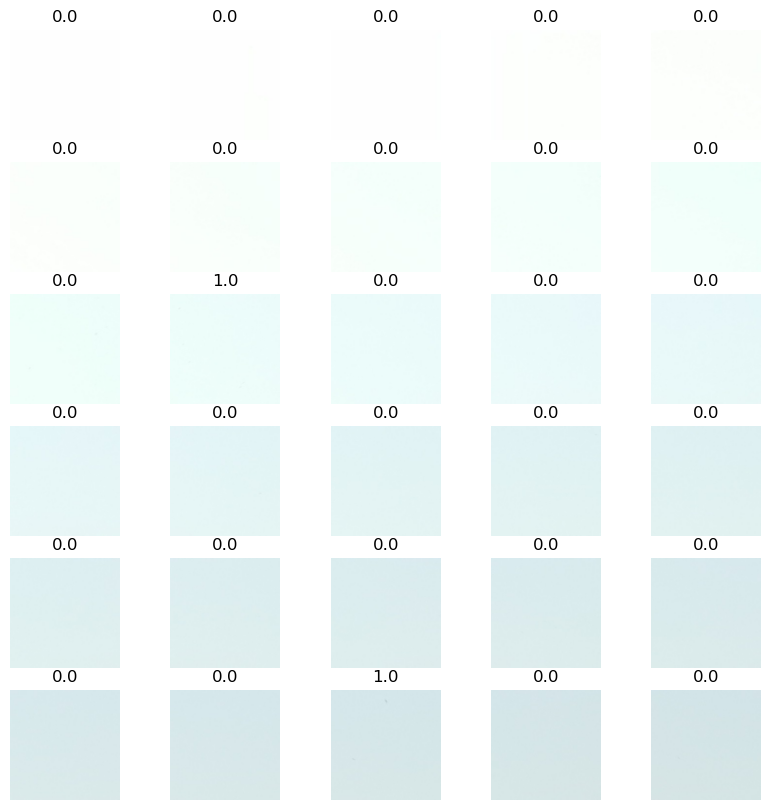

In [206]:
image_batch,_= dataset.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(30):
  ax = plt.subplot(6, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8")) #
  plt.title(predicted_id_m[i])
  plt.axis("off")

## FORCE consistency in classification

In [268]:
for n in imgNodes:
    # select imgTrainingNodes
    indices=[i for i,tn in enumerate(imgTrainingNodes) if tn.isDerivedFrom ==n.subject]
    
    #update materialpredictions
    shape=(math.floor(n.imageHeight/pixelRange),math.floor(n.imageWidth/pixelRange))
    materialPrediction=[int(imgTrainingNodes[i].materialPrediction) for i in indices]
    materialPrediction2=pt.filter_img_classifcation_by_neighbors(materialPrediction,shape,filteringWeight)
   
    #update building technique predictions
    techniquePrediction=[int(imgTrainingNodes[i].techniquePrediction) for i in indices]
    techniquePrediction2=pt.filter_img_classifcation_by_neighbors(techniquePrediction,shape,filteringWeight)
    
    #update damage predictions
    damagePrediction=[int(imgTrainingNodes[i].damagePrediction) for i in indices]
    damagePrediction2=pt.filter_img_classifcation_by_neighbors(damagePrediction,shape,filteringWeight)

    #create secondary classification
    for i,ind in enumerate(indices):
        imgTrainingNodes[ind].materialPrediction2=materialPrediction2[i]
        imgTrainingNodes[ind].techniquePrediction2=techniquePrediction2[i]
        imgTrainingNodes[ind].damagePrediction2=damagePrediction2[i]

## SHOW RESULTS FOR FULL PICTURE

(optional) Compile result for complete images

In [284]:
import copy

images=[]
for n in imgNodes[0::10]:
    image=copy.deepcopy(n.resource)
    # select nodes
    nodeList=[tn for tn in imgTrainingNodes if tn.isDerivedFrom ==n.subject]
    
    #create mask from roi
    for i,c in enumerate(class_names_m):
        roiList= [t.roi for t in nodeList if t.materialPrediction2==c and not any(np.isnan([p for p in t.point]))] 
        if len(roiList) >0:
            for roi in roiList:
                roi=image[roi[0]:roi[1],roi[2]:roi[3]] 
                roi[:,:,:]=colors[i]
    images.append(image)   

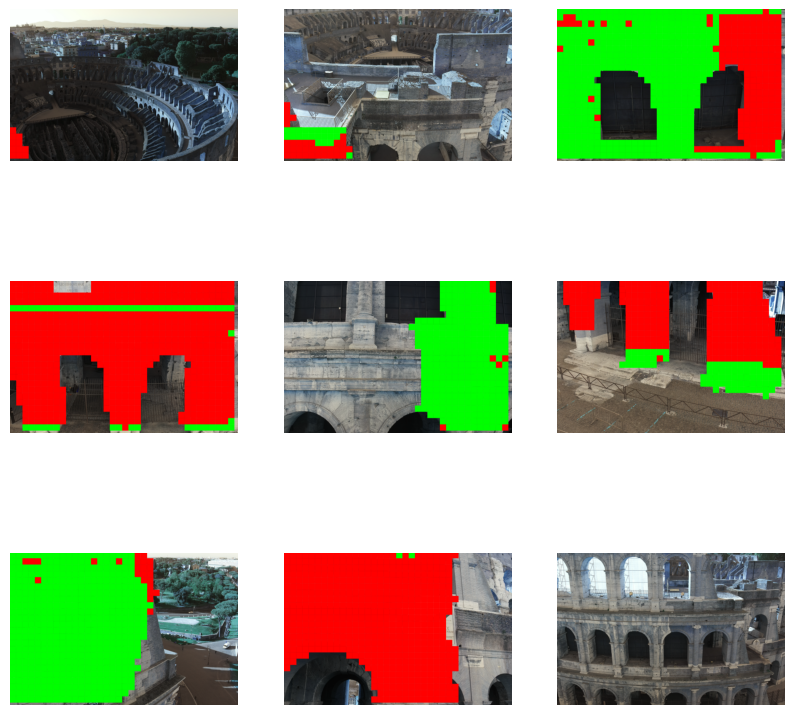

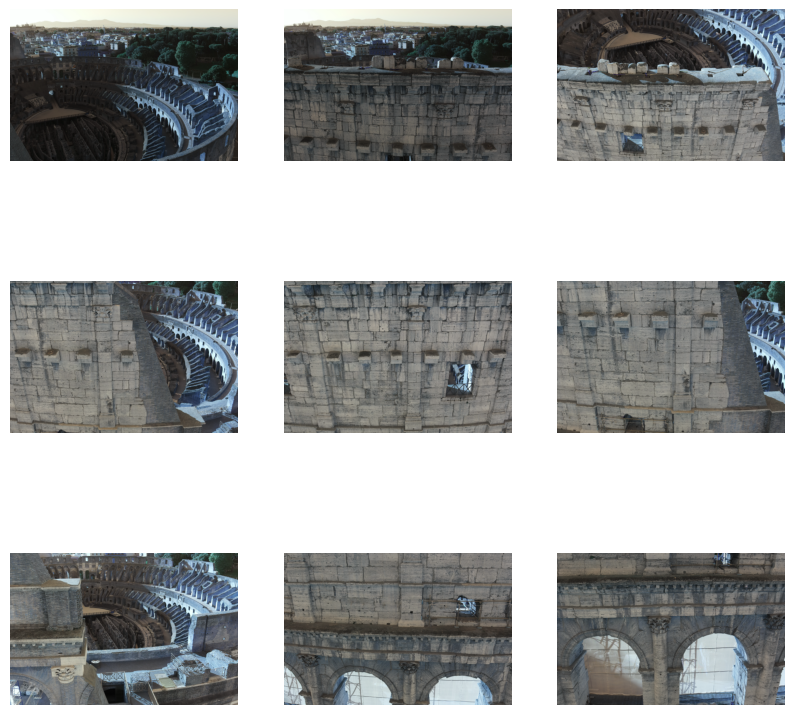

In [285]:
import math
n=[0,9]
plt.figure(figsize=(10, 10))
# for img in [n.resource for n in imgNodes]:
for i,img in enumerate(images[n[0]:n[1]]):
    ax = plt.subplot(3, 3, i+1 )
    # plt.imshow(cv2.resize(img, (math.ceil(img.shape[1]/16),math.ceil(img.shape[0]/16))))
    plt.imshow(iu.image_resize(img,scale=1/16))
    plt.axis("off")
plt.figure(figsize=(10, 10))
# for img in [n.resource for n in imgNodes]:
for i,img in enumerate([t for t in imgNodes[n[0]:n[1]]]):
    ax = plt.subplot(3, 3, i+1 )
    # plt.imshow(cv2.resize(img, (math.ceil(img.shape[1]/16),math.ceil(img.shape[0]/16))))
    plt.imshow(iu.image_resize(img.resource,scale=1/16))
    plt.axis("off")

## ASSIGN IMAGE CLASSIFICATION TO POINT CLOUD

Assign Materials

In [271]:
pointClouds=[]
for c in class_names_m:
    pcd=o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector([n.point for n in imgTrainingNodes if n.materialPrediction2 == c and not any(np.isnan([p for p in n.point]))])
    pointClouds.append(pcd)
arrM=pt.assign_point_cloud_information(pcdNode.resource,pointClouds,class_names_m)

Assign Building Techniques

In [272]:
pointClouds=[]
for c in class_names_tc:
    pcd=o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector([n.point for n in imgTrainingNodes if n.techniquePrediction2 == c and not any(np.isnan([p for p in n.point]))])
    pointClouds.append(pcd)
arrTC=pt.assign_point_cloud_information(pcdNode.resource,pointClouds,class_names_tc)

Assign Damages

In [273]:
pointClouds=[]
for c in class_names_d:
    pcd=o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector([n.point for n in imgTrainingNodes if n.damagePrediction2 == c and not any(np.isnan([p for p in n.point]))])
    pointClouds.append(pcd)
arrD=pt.assign_point_cloud_information(pcdNode.resource,pointClouds,class_names_d)
pointClouds=None

Visualize the img generated identity point clouds.

In [44]:
# o3d.visualization.draw_geometries([ref_cloud]+[line_set]+[pcdNode.resource])
# o3d.visualization.draw_geometries([ref_cloud]+[pcdNode.resource])
# o3d.visualization.draw_geometries([pcdNode.resource])

## Assign classification to the las file.

In [276]:
gmu.las_add_extra_dimensions(las,(arrM,arrTC,arrD),['imageMatClassification','imageTCClassification','imageDClassification'],['uint8','uint8','uint8'])
print(list(las.point_format.dimension_names))

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'red', 'green', 'blue', 'bimDistance', 'bimMaterial2', 'bimMaterial1', 'bimTC', '02 TC', '03 D', '01 Materiali', 'imageMatClassification', 'imageTCClassification', 'imageDClassification']


In [277]:
print(las['imageMatClassification'])
print(las['imageTCClassification'])
print(las['imageDClassification'])

[1 0 0 ... 0 0 0]
[2 0 0 ... 0 0 0]
[2 2 2 ... 1 1 1]


Export las file

In [278]:
las.write(outputlasPath)

In [ ]:
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': 'D:\\Data\\2023-01 Colosseum\\Research\\IMG\\cameras.xml',
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 3936.0,
 'imageHeight': 2624.0,
 'focalLength35mm': 2668.8837741268403,
 '_subject': rdflib.term.URIRef('file:///DSC03492'),
 '_graph': <Graph identifier=Nf95dd642d1f749729769800c1d4c1513 (<class 'rdflib.graph.Graph'>)>,
 '_graphPath': 'D:\\Data\\2023-01 Colosseum\\Research\\IMG\\imgGraph.ttl',
 '_path': 'D:\\Data\\2023-01 Colosseum\\Research\\IMG\\DSC03492.JPG',
 '_name': 'DSC03492',
 '_timestamp': '2022-05-06T10:05:17',
 '_resource': array([[[ 95, 120, 154],
         [ 93, 118, 152],
         [ 91, 116, 150],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 93, 121, 151],
         [ 95, 123, 153],
         [ 94, 120, 150],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 99, 130, 155],
         [101, 132, 157],
         [ 98, 128, 153],
